# Test Case 4: Currents varying in space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Energy_Calculation_Test import Energy

### Project Data

In [2]:
x = np.linspace(-50, 0, 1000)                  #x-coordinates of sailing route, cross-shore
y = np.linspace(0, 0, 1000)                    #y-coordinates of sailing route, alongshore
depth = np.linspace(50, 15, 1000)              #Depth corresponding to x,y-coordinates

#Vessel properties
ship_properties = {"P": 10000,                 #Desired constant power of vessel [kW]
                   "T": 13,                    #Draft of vessel [m]
                   "L": 159,                   #Length at waterline [m]
                   "B": 32,                    #Breadth [m]
                   "A": 22.5,                  #Rudder area [m^2]
                   "P_installed": 25000,       #Total installed power [kW]
                   "C_B": 0.85,                #Block coefficient [-]
                   "x0": 1,                     #number of propellor screws [-]     
                   "N": 0.0028                 #Vertical eddy viscosity [m^2/s]
                  }

### Define flow field and add to class

In [3]:
def flow_field(self, x):
    u = -1 * np.exp(x/50)                     #Cross-shore current, positive in x-direction, corresponding to x,y-coordinates
    v = 1 * np.exp(x/50)                      #Alongshore current, positive in y-direction, corresponding to x,y-coordinates

    return u, v

Energy.flow_field = flow_field

### plan view of project data

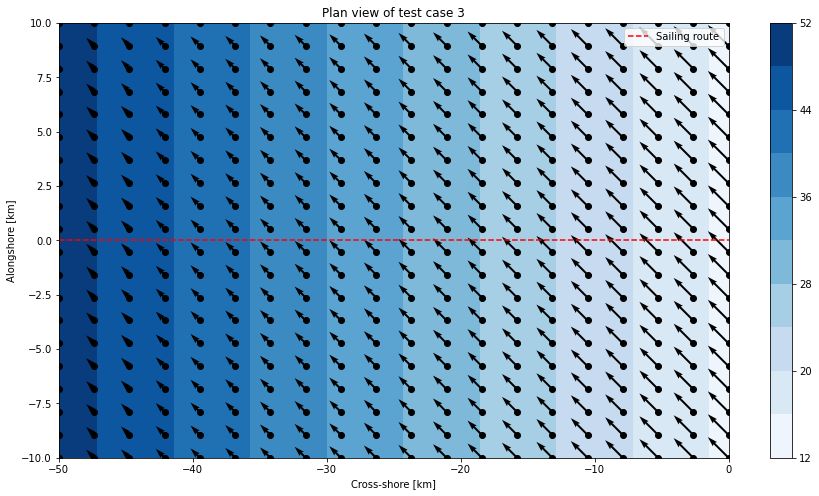

In [4]:
x_grid = np.linspace(-50, 0, 20)
y_grid = np.linspace(-10, 10, 20)

x_grid, y_grid = np.meshgrid(x_grid, y_grid)

contour = np.linspace(50, 15, 20)
depth_contour = []

for i in range(len(x_grid)):
    depth_contour.append(contour)

u_grid = -1 * np.exp(x_grid/50)
v_grid = 1 * np.exp(x_grid/50)
    
plt.figure(figsize=(15, 8))
plt.plot(x_grid, y_grid, 'ko')
plt.plot(x, y, label='Sailing route', color='r', linestyle='--')
cp = plt.contourf(x_grid, y_grid, depth_contour, levels=10, cmap='Blues')
plt.colorbar(cp)
plt.quiver(x_grid, y_grid, u_grid, v_grid)
plt.xlabel('Cross-shore [km]')
plt.ylabel('Alongshore [km]')
plt.title('Plan view of test case 3')
plt.legend();

### Creating object and determining sailing speed, drift angle, speed_overground and time

Class "Energy" has 4 input variables:
- The x and y coordinates
- Depth corresponding to the x and y coordinates 
- A dictionary containing ship_properties as above, also including the vertical eddy viscosity which determines the vertical structure of the velocity.

It has 7 methods:
- __Energy.\_\_init\_\_(self, x, y, depth, ship_properties, \*args, \**kwargs)__: The standard init method 
- __Energy.HM(self, V, depth, angle)__: The Holtrop and Mennen method. Returns the Total Power, Total Resistance, Drag Resistance and HM Resistance
- __Energy.Drag(self, V, angle)__: The drag resistance method. returns the Drag Resistance. This method is called in the Holtrop and Mennen metho__(Energy.HM(self, V, depth, angle))__
- __Energy.solve_velocity_drift(self, starting_time)__: The velocity and drift angle method. Returns the velocity (sailing speed),  drift angle, speed overground and time for a desired constant power, depth, and velocity field. This method uses the bisection method algorithm to calculate the velocity and drift angle that are both dependent on eachother. The starting time is used to calculate the total project duration and, if the flow field is time-dependent, the initial magnitudes for the cross-shore and alongshore currents. 
- __Energy.Prandle_Heaps(self, t, x, D, T)__: A flow field method describing the Prandle and Heaps vertical structure of the velocity. This method returns the cross-shore and alongshore magnitudes of the current, which is vertically integrated from the water surface to the bottom of the vessel. This flow field will be used when no other external flow field is defined in the notebook.
    - t = time calculated based on distance and speed overground (speed w.r.t. water + currents)
    - x = cross-shore distance, positive in landward direction and 0 at the coastline
    - D = depth corresponding to the x- and y-coordinate
    - T = draft of vessel
- __Energy.drift_angle(V, u, v, x, y)__: The drift angle method. Returns the drift angle. This is a static method.
- __Energy.speed_overground(V, u, v, x, y)__: The speed overground method. Returns the speed overground magnitude which is needed to calculate the state of the flow field in the next point along the sailing route. This is also a static method.

In [5]:
Energy_object = Energy(x, y, depth, ship_properties)

velocity, drift_angle, speed_overground, time = Energy_object.solve_velocity_drift(starting_time=0)

C:\ProgramData\anaconda3\envs\Thesis\lib\site-packages\Energy_Calculation_Test.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  R_B = 0.11 * np.exp(-3 * P_B**-2) * F_ni**3 * A_BT**1.5 * rho * g / (1 + F_ni**2)


Text(0, 0.5, 'Drift angle [°]')

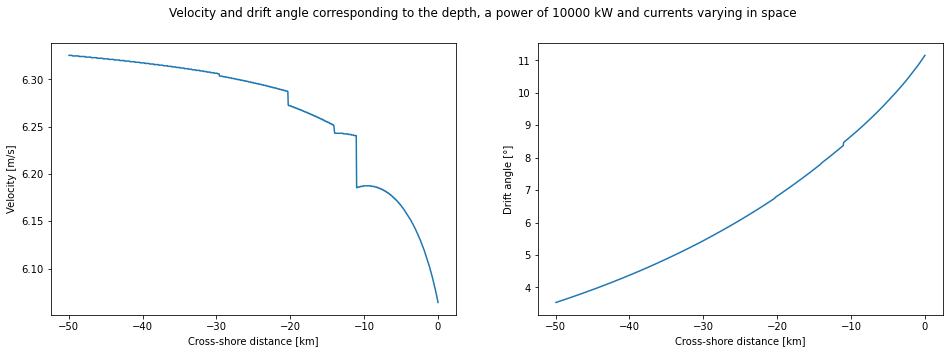

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

fig.suptitle(f'Velocity and drift angle corresponding to the depth, a power of {ship_properties["P"]} kW and currents varying in space')

ax1.plot(x[1:], velocity)
ax1.set_xlabel('Cross-shore distance [km]')
ax1.set_ylabel('Velocity [m/s]')

ax2.plot(x[1:], drift_angle)
ax2.set_xlabel('Cross-shore distance [km]')
ax2.set_ylabel('Drift angle [\xb0]')

### No-drag reference case

In [7]:
def flow_field(self):
    u = -1 * np.exp(x/50)
    v = np.zeros(len(x))

    return u, v

Energy.flow_field = flow_field

velocity_nodrag, drift_angle_nodrag, speed_overground_nodrag, time_nodrag = Energy_object.solve_velocity_drift(starting_time=0)

C:\ProgramData\anaconda3\envs\Thesis\lib\site-packages\Energy_Calculation_Test.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  R_B = 0.11 * np.exp(-3 * P_B**-2) * F_ni**3 * A_BT**1.5 * rho * g / (1 + F_ni**2)


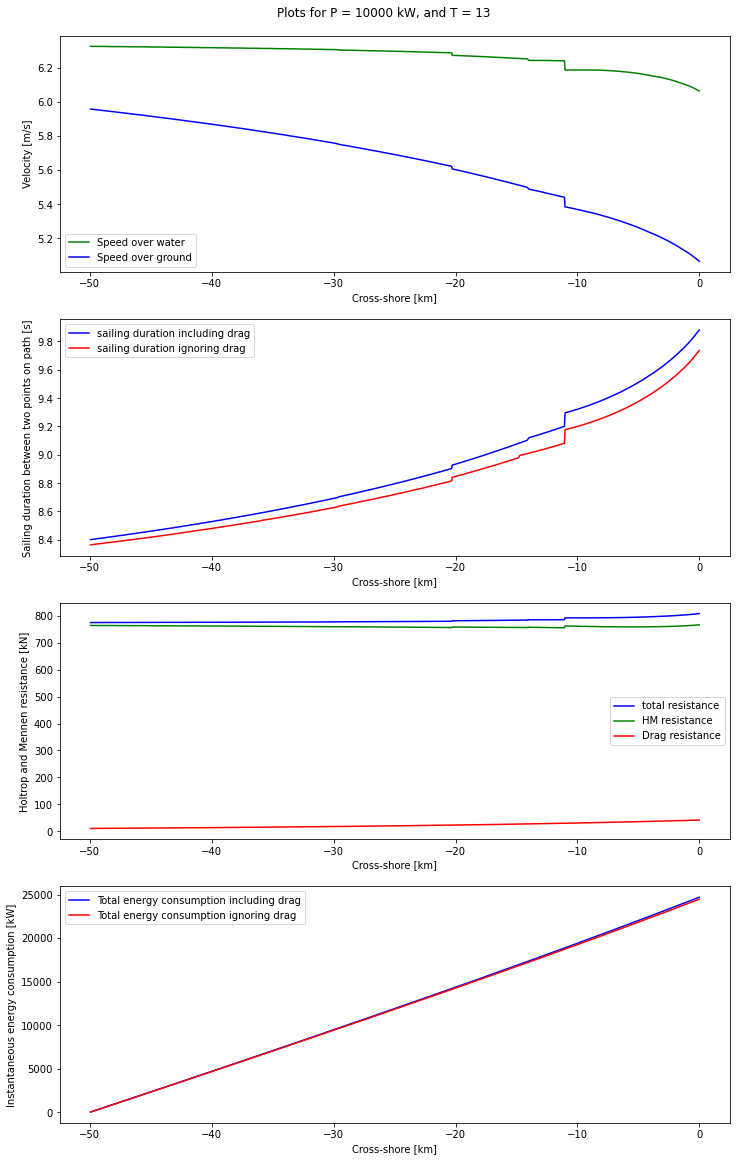

In [8]:
#Calculating sailing duration, resistance and energy consumption:
P = ship_properties["P"]
T = ship_properties["T"]

#Calculating sailing duration, resistance and energy consumption:
R_total = []
HM_resistance = []
Drag_resistance = []
energy = []
energy_nodrag = []
duration = []
duration_nodrag = []

for i in range(len(x) - 1):  
    sailing_duration = ((x[i+1] - x[i]) * 1000) / speed_overground[i]
    sailing_duration_nodrag = ((x[i+1] - x[i]) * 1000) / speed_overground_nodrag[i]

    R_tot = Energy_object.HM(velocity[i], depth[i], drift_angle[i])[1] / 1000
    R_HM = Energy_object.HM(velocity[i], depth[i], drift_angle[i])[3] / 1000
    R_Drag = Energy_object.HM(velocity[i], depth[i], drift_angle[i])[2] / 1000
    
    HM_resistance.append(R_HM)
    Drag_resistance.append(R_Drag)
    R_total.append(R_tot)
    duration.append(sailing_duration)
    duration_nodrag.append(sailing_duration_nodrag)
    energy.append(P * sailing_duration / (60 * 60))
    energy_nodrag.append(P * sailing_duration_nodrag / (60 * 60))
    
total_duration = [sum(duration[:i+1]) for i in range(len(duration))]
total_duration_nodrag = [sum(duration_nodrag[:i+1]) for i in range(len(duration_nodrag))]
total_energy = [sum(energy[:i+1]) for i in range(len(energy))]
total_energy_nodrag = [sum(energy_nodrag[:i+1]) for i in range(len(energy_nodrag))]

#Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle(f'Plots for P = {P} kW, and T = {T}', y=0.9)

# Plot the velocity over time
ax1.plot(x[1:], velocity, color='g', label ='Speed over water')
ax1.plot(x[1:], speed_overground, color='b', label='Speed over ground')
ax1.set_xlabel('Cross-shore [km]')
ax1.set_ylabel('Velocity [m/s]')
ax1.legend()

# Plot sailing duration between two consecutive x,y coordinates
ax2.plot(x[1:], duration, color='b', label='sailing duration including drag')
ax2.plot(x[1:], duration_nodrag, color='r', label='sailing duration ignoring drag')
ax2.set_xlabel('Cross-shore [km]')
ax2.set_ylabel('Sailing duration between two points on path [s]')
ax2.legend()

# Plot the Holtrop and Mennen resistance over time
ax3.plot(x[1:], R_total, color='b', label='total resistance')
ax3.plot(x[1:], HM_resistance, color='g', label='HM resistance')
ax3.plot(x[1:], Drag_resistance, color='r', label='Drag resistance')
ax3.set_xlabel('Cross-shore [km]')
ax3.set_ylabel('Holtrop and Mennen resistance [kN]')
ax3.legend()

#plot total energy consumption
ax4.plot(x[1:], total_energy, color='b', label='Total energy consumption including drag')
ax4.plot(x[1:], total_energy_nodrag, color='r', label='Total energy consumption ignoring drag')
ax4.set_xlabel('Cross-shore [km]')
ax4.set_ylabel('Instantaneous energy consumption [kW]')
ax4.legend();